In [1]:
import numpy as np
import cv2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist

In [2]:
# Завантаження датасету fashion-mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()



4422102/4422102 [==============================] - 1s 0us/step


In [3]:
# Зміна розміру зображень з 28x28 до 75х75
x_train = np.repeat(np.expand_dims(x_train, axis=-1), 3, axis=-1)
x_test = np.repeat(np.expand_dims(x_test, axis=-1), 3, axis=-1)
x_train = np.asarray([cv2.resize(image, (75, 75)) for image in x_train])
x_test = np.asarray([cv2.resize(image, (75, 75)) for image in x_test])


In [4]:
num_classes = 10

# Використання InceptionV3 як основи моделі
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Додавання власних слоїв на основі InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

87910968/87910968 [==============================] - 4s 0us/step


In [5]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]

In [6]:
# Збірка моделі
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# Компіляція моделі
optimizer = Adam(lr=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Навчання моделі
model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))


Epoch 1/5
938/938 [==============================] - 120s 75ms/step - loss: 0.4912 - accuracy: 0.8432 - val_loss: 0.4033 - val_accuracy: 0.8707
Epoch 2/5
938/938 [==============================] - 66s 70ms/step - loss: 0.3147 - accuracy: 0.8912 - val_loss: 0.5164 - val_accuracy: 0.8880
Epoch 3/5
938/938 [==============================] - 63s 67ms/step - loss: 0.2335 - accuracy: 0.9200 - val_loss: 0.2480 - val_accuracy: 0.9146
Epoch 4/5
938/938 [==============================] - 63s 67ms/step - loss: 0.2524 - accuracy: 0.9148 - val_loss: 10.1998 - val_accuracy: 0.7671
Epoch 5/5
938/938 [==============================] - 63s 67ms/step - loss: 0.2518 - accuracy: 0.9151 - val_loss: 0.2162 - val_accuracy: 0.9253


In [9]:
# Оцінка точності моделі на тестовому наборі даних
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 5s 14ms/step - loss: 0.2162 - accuracy: 0.9253
Test loss: 0.21624836325645447
Test accuracy: 0.9253000020980835


In [10]:
from keras.layers import concatenate
import tensorflow as tf

img_a_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = tf.keras.layers.Dense(16, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(32, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()
     

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 16)           336         ['merge_features[1][0

In [11]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)
     

1/1 [==============================] - 0s 96ms/step


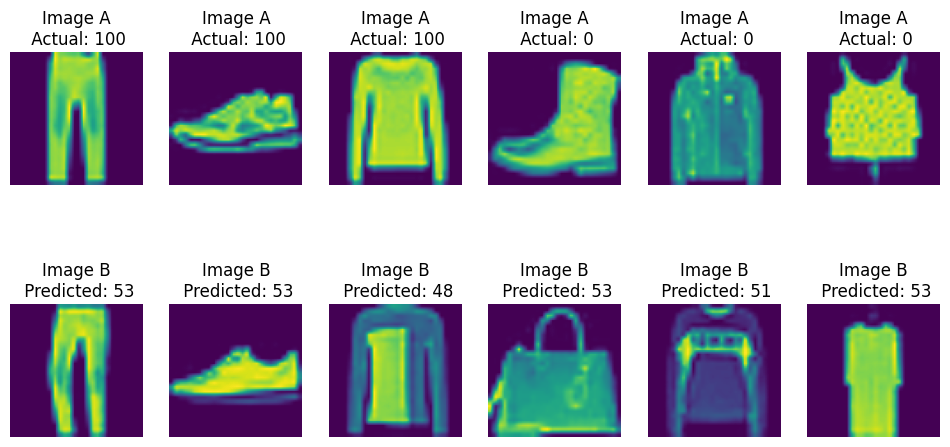

In [12]:

import matplotlib.pyplot as plt
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [13]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 100,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 4,
    verbose = True)

1/1 [==============================] - 0s 24ms/step
Epoch 1/4
100/100 [==============================] - 22s 192ms/step - loss: 0.5842 - mae: 0.4230 - val_loss: 0.6111 - val_mae: 0.4552
Epoch 2/4
100/100 [==============================] - 21s 208ms/step - loss: 0.3649 - mae: 0.2855 - val_loss: 0.4274 - val_mae: 0.3387
Epoch 3/4
100/100 [==============================] - 22s 218ms/step - loss: 0.2374 - mae: 0.1820 - val_loss: 0.2442 - val_mae: 0.1958
Epoch 4/4
100/100 [==============================] - 21s 215ms/step - loss: 0.1782 - mae: 0.1309 - val_loss: 0.1657 - val_mae: 0.1172


1/1 [==============================] - 0s 21ms/step


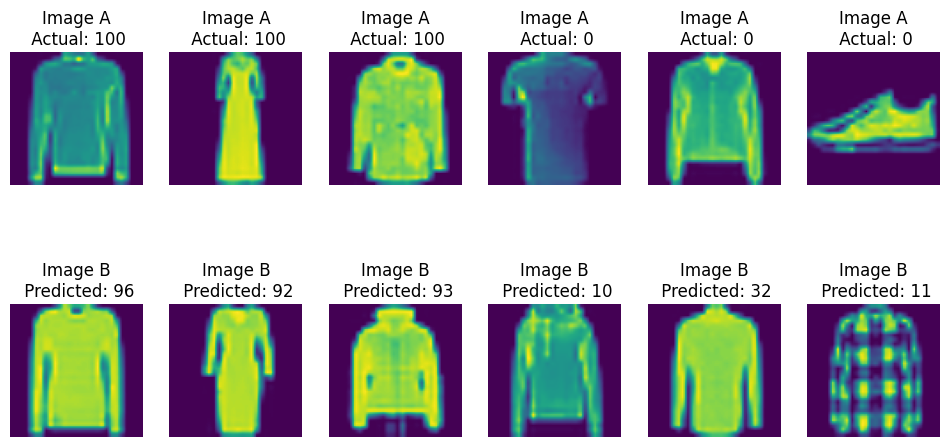

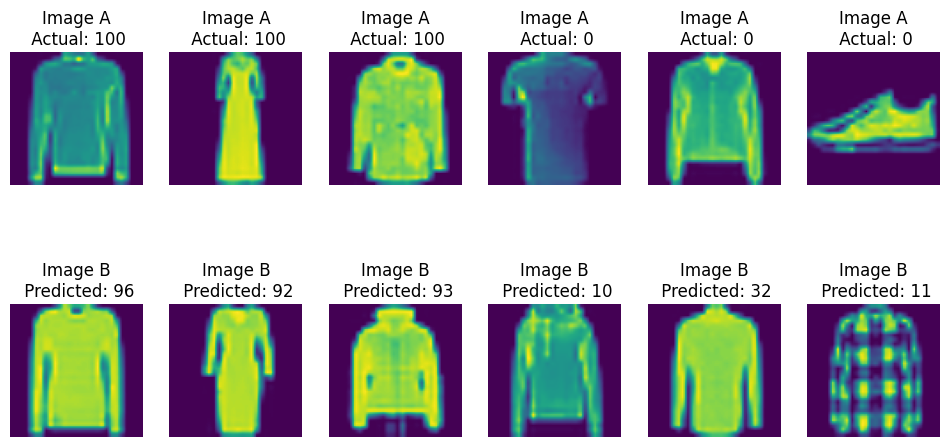

In [14]:
show_model_output()

In [15]:

%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)
     

79/79 [==============================] - 3s 24ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.427s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000003
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.391220
[t-SNE] KL divergence aft

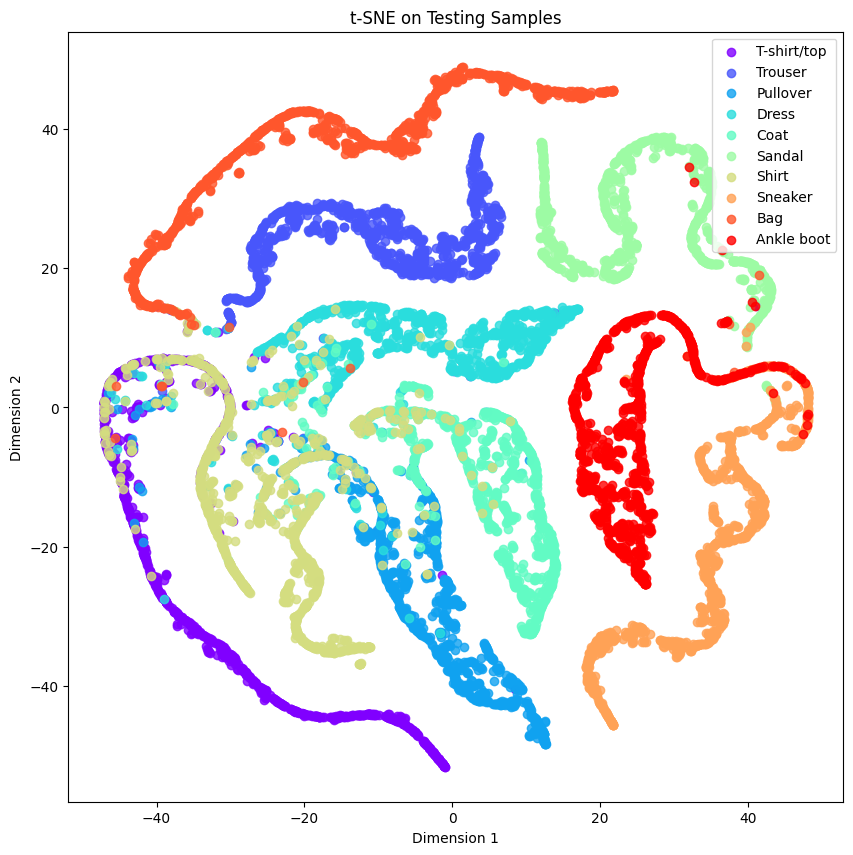

In [16]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show()